# TM10007 Assignment template

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [1]:
# # Run this to use from colab environment
# !pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

### Import packages

In [2]:
from load_data import load_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
import seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

### Self defined functions

In [13]:
def ROC(y_score, y_truth):

    '''
    Plot an ROC curve.
    '''
    # Only take scores for class = 1
    y_score = y_score[:, 1]
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_truth, y_score)
    roc_auc = auc(fpr, tpr)     
    
    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

def prep(features, label):
    # Splitting data in train and test group
    X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=.2, stratify=label)


    def binner(y, class1):
        y_bin = []
        for val in y:
            if val == class1:
                y_bin.append(0)
            else:
                y_bin.append(1) 
        return y_bin
    
    y_train_bin = binner(y_train, 'T12') # make binary y_score
    y_test_bin = binner(y_test, 'T12')

    # Create the dataframe
    outlier_feat = []
    for feature in X_train.columns:
        # IQR
        Q1 = np.percentile(X_train[feature], 25,
                        interpolation = 'midpoint')
        
        Q3 = np.percentile(X_train[feature], 75,
                        interpolation = 'midpoint')
        IQR = Q3 - Q1
    
        if not IQR == 0:
            # Upper bound
            X_train.loc[X_train[feature] > (Q3+1.5*IQR),feature] = Q3
            # Lower bound
            X_train.loc[X_train[feature] < (Q1-1.5*IQR),feature] = Q1


    for feature in X_test.columns:
        
        # IQR
        Q1 = np.percentile(X_test[feature], 25,
                        interpolation = 'midpoint')
        
        Q3 = np.percentile(X_test[feature], 75,
                        interpolation = 'midpoint')
        IQR = Q3 - Q1
        
        if not IQR == 0:
            # Upper bound
            X_test.loc[X_test[feature] > (Q3+1.5*IQR),feature] = Q3
            # Lower bound
            X_test.loc[X_test[feature] < (Q1-1.5*IQR),feature] = Q1

    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns = features.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns = features.columns)

    # Construct classifiers
    coefs = []
    accuracies = []
    times = []

    n_alphas = 100
    alphas = np.logspace(-7, -1, n_alphas)

    for a in alphas:
        # Fit classifier
        clf = Lasso(alpha=a, fit_intercept=False,tol=0.044)
        clf.fit(X_train_scaled, y_train_bin) 
        y_pred = clf.predict(X_test_scaled)
        
        # Append statistics
        accuracy = clf.score(X_train_scaled,y_train_bin)
        accuracies.append(accuracy)
        coefs.append(clf.coef_)

    # # Weights
    # plt.figure()
    # ax = plt.gca()
    # ax.plot(alphas, np.squeeze(coefs))
    # ax.set_xscale('log')
    # ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    # plt.xlabel('alpha')
    # plt.ylabel('weights')
    # plt.title('Lasso coefficients as a function of the regularization')
    # plt.axis('tight')
    # plt.show()

    # # Performance
    # plt.figure()
    # ax = plt.gca()
    # ax.plot(alphas, accuracies)
    # ax.set_xscale('log')
    # ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    # plt.xlabel('alpha')
    # plt.ylabel('accuracies')
    # plt.title('Performance as a function of the regularization')
    # plt.axis('tight')
    # plt.show()


    selector = SelectFromModel(estimator=Lasso(alpha=10**(-6), tol=0.002248888888888889), threshold='median')
    selector.fit(X_train_scaled, y_train_bin)
    n_original = X_train_scaled.shape[1]
    X_train_fs = selector.transform(X_train_scaled)
    X_test_fs = selector.transform(X_test_scaled)
    n_selected = X_train_fs.shape[1]
    # print(f"Selected {n_selected} from {n_original} features.")

    N_COMP = .9
    pca = PCA(n_components=N_COMP)
    pca.fit(X_train_fs)
    X_train_pca = pca.transform(X_train_fs)
    X_test_pca = pca.transform(X_test_fs)

    # print(f'Number of features extracted from the PCA: {X_test_pca.shape[1]}')



    # SVC


    # Create a 3 fold stratified CV iterator
    cv_3fold = model_selection.StratifiedKFold(n_splits=3)
    results = []
    best_cls = []
    y_train_a = y_train.to_numpy()

    # Loop over the folds
    for train_opt_index, validation_index in cv_3fold.split(X_train_pca,y_train_a):
        # Split the data properly
        X_train_opt = X_train_pca[train_opt_index]
        y_train_opt = y_train_a[train_opt_index]
        
        X_validation = X_train_pca[validation_index]
        y_validation = y_train_a[validation_index]
        
        # Create a grid search to find the optimal k using a gridsearch and 3-fold cross validation
        # Same as above
        parameters = {
            # 'coef0':list(np.linspace(0.01,1,11)),
            'C':list(np.linspace(0.01,1,100)),
            # 'kernel' : ['linear','sigmoid'],
            # 'gamma' : ['scale','auto'],
            # 'degree' : [1, 2, 3, 4, 5]
        }
        svm_clf = SVC(kernel = 'linear', probability=True)
        cv_3fold = model_selection.StratifiedKFold(n_splits=3)
        grid_search = model_selection.GridSearchCV(svm_clf, parameters, cv=cv_3fold, scoring='roc_auc')
        grid_search.fit(X_train_opt, y_train_opt)
        
        # Get resulting classifier
        clf = grid_search.best_estimator_
        print(f'Best classifier: C={clf.C}')
        best_cls.append(clf.C)
        
        # Test the classifier on the train_opt data
        probabilities_train_opt = clf.predict_proba(X_train_opt)
        scores_train_opt = probabilities_train_opt[:, 1]
        
        # Get the auc
        auc_train_opt = metrics.roc_auc_score(y_train_opt, scores_train_opt)
        results.append({
            'auc': auc_train_opt,
            'n': clf.C,
            'set': 'train_opt'
        })

        # Test the classifier on the test data
        probabilities = clf.predict_proba(X_validation)
        scores = probabilities[:, 1]
        
        # Get the auc
        auc = metrics.roc_auc_score(y_validation, scores)
        results.append({
            'auc': auc,
            'n': clf.C,
            'set': 'validation'
        })
        
    # Create results dataframe and plot it
    results = pd.DataFrame(results)
    seaborn.boxplot(y='auc', x='set', data=results)

    optimal_c = float(np.mean(best_cls))
    # print(f"The optimal C={optimal_c}")
    # print(results)


    # Use the optimal parameters without any tuning to validate the optimal classifier
    clf = SVC(kernel = 'linear', probability=True, C=optimal_c)
    # Fit on the entire dataset
    clf.fit(X_train_pca, y_train)

    # Test the classifier on the indepedent test data
    probabilities_train = clf.predict_proba(X_train_pca)
    probabilities_test = clf.predict_proba(X_test_pca)
    scores_train = probabilities_train[:, 1]
    scores_test = probabilities_test[:, 1]

    # Get the auc
    auc_svc_train = metrics.roc_auc_score(y_train, scores_train)
    auc_svc_test = metrics.roc_auc_score(y_test, scores_test)
    # print(f'The AUC on the test set is {auc_svc_test} using a {optimal_c} Slack')



#  KNN

    # Create a 3 fold stratified CV iterator
    cv_3fold = model_selection.StratifiedKFold(n_splits=3)
    results = []
    best_cls = []
    y_train_a = y_train.to_numpy()

    # Loop over the folds
    for train_opt_index, validation_index in cv_3fold.split(X_train_pca,y_train_a):
        # Split the data properly
        X_train_opt = X_train_pca[train_opt_index]
        y_train_opt = y_train_a[train_opt_index]
        
        X_validation = X_train_pca[validation_index]
        y_validation = y_train_a[validation_index]
        
        # Create a grid search to find the optimal k using a gridsearch and 3-fold cross validation
        # Same as above
        parameters = {
            'n_neighbors': list(range(1,31)),
        }
        knn_clf = KNeighborsClassifier(weights='distance')
        cv_3fold = model_selection.StratifiedKFold(n_splits=3)
        grid_search = model_selection.GridSearchCV(knn_clf, parameters, cv=cv_3fold, scoring='roc_auc')
        grid_search.fit(X_train_opt, y_train_opt)
        
        # Get resulting classifier
        clf = grid_search.best_estimator_
        print(f'Best classifier: n={clf.n_neighbors}')
        best_cls.append(clf.n_neighbors)
        
        # Test the classifier on the train_opt data
        probabilities_train_opt = clf.predict_proba(X_train_opt)
        scores_train_opt = probabilities_train_opt[:, 1]
        
        # Get the auc
        auc_train_opt = metrics.roc_auc_score(y_train_opt, scores_train_opt)
        results.append({
            'auc': auc_train_opt,
            'k': clf.n_neighbors,
            'set': 'train_opt'
        })

        # Test the classifier on the test data
        probabilities = clf.predict_proba(X_validation)
        scores = probabilities[:, 1]
        
        # Get the auc
        auc = metrics.roc_auc_score(y_validation, scores)
        results.append({
            'auc': auc,
            'k': clf.n_neighbors,
            'set': 'validation'
        })
        
    # Create results dataframe and plot it
    results = pd.DataFrame(results)
    seaborn.boxplot(y='auc', x='set', data=results)

    optimal_n = int(np.mean(best_cls))
    # print(f"The optimal k={optimal_n}")
    # print(results)


    # Use the optimal parameters without any tuning to validate the optimal classifier
    clf = KNeighborsClassifier(weights='distance', n_neighbors=optimal_n)
    # Fit on the entire dataset
    clf.fit(X_train_pca, y_train)

    # Test the classifier on the indepedent test data
    probabilities_train = clf.predict_proba(X_train_pca)
    probabilities_test = clf.predict_proba(X_test_pca)
    scores_train = probabilities_train[:, 1]
    scores_test = probabilities_test[:, 1]

    # Get the auc
    auc_knn_train = metrics.roc_auc_score(y_train, scores_train)
    auc_knn_test = metrics.roc_auc_score(y_test, scores_test)
    # print(f'The AUC on the test set is {auc_knn_test} using a {optimal_n}-NN')



    return auc_svc_train, auc_svc_test, auc_knn_train, auc_knn_test

### Loading data and splitting

In [4]:
ran_state = 42

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

features = data.drop(columns=['label'])
label = data.label


# Splitting data in train and test group
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=.2, stratify=label, random_state=ran_state)


def binner(y, class1):
  y_bin = []
  for val in y:
    if val == class1:
      y_bin.append(0)
    else:
      y_bin.append(1) 
  return y_bin
  
y_train_bin = binner(y_train, 'T12') # make binary y_score
y_test_bin = binner(y_test, 'T12')

The number of samples: 113
The number of columns: 160


## Preprocessing

### Removing outliers

In [5]:
# Create the dataframe
outlier_feat = []
for feature in X_train.columns:
    # IQR
    Q1 = np.percentile(X_train[feature], 25,
                    interpolation = 'midpoint')
    
    Q3 = np.percentile(X_train[feature], 75,
                    interpolation = 'midpoint')
    IQR = Q3 - Q1
 
    if not IQR == 0:
        # Upper bound
        X_train.loc[X_train[feature] > (Q3+1.5*IQR),feature] = Q3
        # Lower bound
        X_train.loc[X_train[feature] < (Q1-1.5*IQR),feature] = Q1


for feature in X_test.columns:
    
    # IQR
    Q1 = np.percentile(X_test[feature], 25,
                    interpolation = 'midpoint')
    
    Q3 = np.percentile(X_test[feature], 75,
                    interpolation = 'midpoint')
    IQR = Q3 - Q1
    
    if not IQR == 0:
        # Upper bound
        X_test.loc[X_test[feature] > (Q3+1.5*IQR),feature] = Q3
        # Lower bound
        X_test.loc[X_test[feature] < (Q1-1.5*IQR),feature] = Q1


/Users/bramschalkwijk/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### Scaling

In [6]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = features.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = features.columns)


## Feature selection

### LASSO

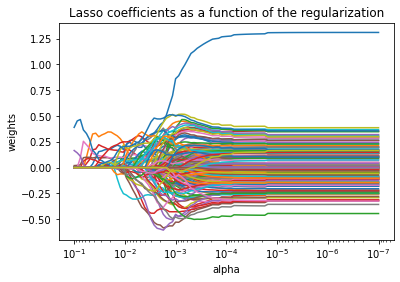

<Figure size 432x288 with 0 Axes>

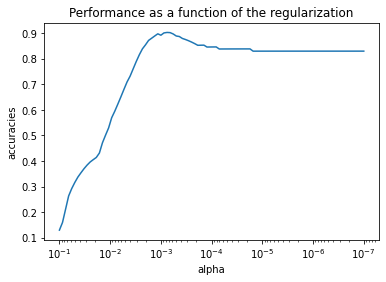

<Figure size 432x288 with 0 Axes>

In [7]:
# Construct classifiers
coefs = []
accuracies = []
times = []

n_alphas = 100
alphas = np.logspace(-7, -1, n_alphas)

for a in alphas:
    # Fit classifier
    clf = Lasso(alpha=a, fit_intercept=False,tol=0.044, random_state=ran_state)
    clf.fit(X_train_scaled, y_train_bin) 
    y_pred = clf.predict(X_test_scaled)
    
    # Append statistics
    accuracy = clf.score(X_train_scaled,y_train_bin)
    accuracies.append(accuracy)
    coefs.append(clf.coef_)

# Weights
plt.figure()
ax = plt.gca()
ax.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()
plt.savefig('/Users/bramschalkwijk/Documents on mac/TM12007---H-N-group-12/figures/weights_lasso.png')

# Performance
plt.figure()
ax = plt.gca()
ax.plot(alphas, accuracies)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('accuracies')
plt.title('Performance as a function of the regularization')
plt.axis('tight')
plt.show()
plt.savefig('/Users/bramschalkwijk/Documents on mac/TM12007---H-N-group-12/figures/performance_lasso.png')

#### Select features

In [8]:
selector = SelectFromModel(estimator=Lasso(alpha=10**(-6), tol=0.002248888888888889, random_state=ran_state), threshold='median')
selector.fit(X_train_scaled, y_train_bin)
n_original = X_train_scaled.shape[1]
X_train_fs = selector.transform(X_train_scaled)
X_test_fs = selector.transform(X_test_scaled)
n_selected = X_train_fs.shape[1]
print(f"Selected {n_selected} from {n_original} features.")

Selected 80 from 159 features.


## PCA

In [9]:
N_COMP = .9
pca = PCA(n_components=N_COMP, random_state=ran_state)
pca.fit(X_train_fs)
X_train_pca = pca.transform(X_train_fs)
X_test_pca = pca.transform(X_test_fs)

print(f'Number of features extracted from the PCA: {X_test_pca.shape[1]}')


Number of features extracted from the PCA: 25


# Classifier

#### SVM

Best classifier: C=0.74
Best classifier: C=0.23
Best classifier: C=0.45
The optimal C=0.47333333333333333
        auc     n         set
0  0.986652  0.74   train_opt
1  0.733333  0.74  validation
2  0.903226  0.23   train_opt
3  0.920000  0.23  validation
4  0.942222  0.45   train_opt
5  0.888393  0.45  validation
The AUC on the test set is 0.8257575757575757 using a 0.47333333333333333 Slack


TypeError: 'numpy.float64' object is not callable

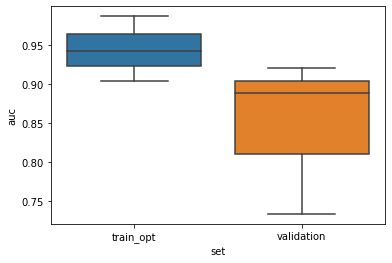

In [15]:
# Create a 3 fold stratified CV iterator
cv_3fold = model_selection.StratifiedKFold(n_splits=3)
results = []
best_cls = []
y_train_a = y_train.to_numpy()

# Loop over the folds
for train_opt_index, validation_index in cv_3fold.split(X_train_pca,y_train_a):
    # Split the data properly
    X_train_opt = X_train_pca[train_opt_index]
    y_train_opt = y_train_a[train_opt_index]
    
    X_validation = X_train_pca[validation_index]
    y_validation = y_train_a[validation_index]
    
    # Create a grid search to find the optimal k using a gridsearch and 3-fold cross validation
    # Same as above
    parameters = {
        # 'coef0':list(np.linspace(0.01,1,11)),
        'C':list(np.linspace(0.01,1,100)),
        # 'kernel' : ['linear','sigmoid'],
        # 'gamma' : ['scale','auto'],
        # 'degree' : [1, 2, 3, 4, 5]
    }
    svm_clf = SVC(kernel = 'linear', probability=True, random_state=ran_state)
    cv_3fold = model_selection.StratifiedKFold(n_splits=3)
    grid_search = model_selection.GridSearchCV(svm_clf, parameters, cv=cv_3fold, scoring='roc_auc')
    grid_search.fit(X_train_opt, y_train_opt)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: C={clf.C}')
    best_cls.append(clf.C)
    
    # Test the classifier on the train_opt data
    probabilities_train_opt = clf.predict_proba(X_train_opt)
    scores_train_opt = probabilities_train_opt[:, 1]
    
    # Get the auc
    auc_train_opt = metrics.roc_auc_score(y_train_opt, scores_train_opt)
    results.append({
        'auc': auc_train_opt,
        'n': clf.C,
        'set': 'train_opt'
    })

    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_validation)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_validation, scores)
    results.append({
        'auc': auc,
        'n': clf.C,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
seaborn.boxplot(y='auc', x='set', data=results)

optimal_c = float(np.mean(best_cls))
print(f"The optimal C={optimal_c}")
print(results)


# Use the optimal parameters without any tuning to validate the optimal classifier
clf = SVC(kernel = 'linear', probability=True, C=optimal_c, random_state=ran_state)
# Fit on the entire dataset
clf.fit(X_train_pca, y_train)

# Test the classifier on the indepedent test data
probabilities_train = clf.predict_proba(X_train_pca)
probabilities_test = clf.predict_proba(X_test_pca)
scores_train = probabilities_train[:, 1]
scores_test = probabilities_test[:, 1]

# Get the auc
auc_svc_train = metrics.roc_auc_score(y_train, scores_train)
auc_svc_test = metrics.roc_auc_score(y_test, scores_test)
print(f'The AUC on the test set is {auc_svc_test} using a {optimal_c} Slack')

ROC(probabilities_test,y_test_bin)

#### KNN

Best classifier: n=4
Best classifier: n=5
Best classifier: n=6
The optimal k=5
        auc  k         set
0  1.000000  4   train_opt
1  0.733333  4  validation
2  1.000000  5   train_opt
3  0.897778  5  validation
4  1.000000  6   train_opt
5  0.799107  6  validation
The AUC on the test set is 0.7954545454545454 using a 5-NN


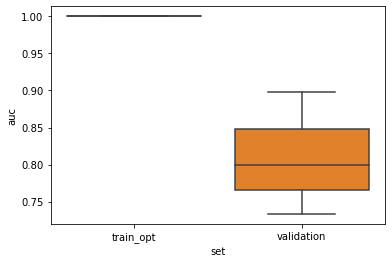

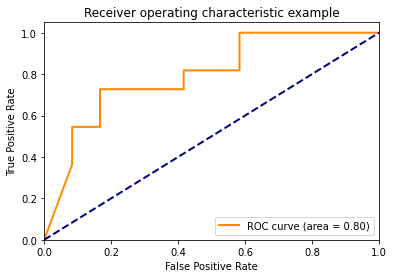

In [ ]:
# Create a 3 fold stratified CV iterator
cv_3fold = model_selection.StratifiedKFold(n_splits=3)
results = []
best_cls = []
y_train_a = y_train.to_numpy()

# Loop over the folds
for train_opt_index, validation_index in cv_3fold.split(X_train_pca,y_train_a):
    # Split the data properly
    X_train_opt = X_train_pca[train_opt_index]
    y_train_opt = y_train_a[train_opt_index]
    
    X_validation = X_train_pca[validation_index]
    y_validation = y_train_a[validation_index]
    
    # Create a grid search to find the optimal k using a gridsearch and 3-fold cross validation
    # Same as above
    parameters = {
        'n_neighbors': list(range(1,31)),
    }
    knn_clf = KNeighborsClassifier(weights='distance')
    cv_3fold = model_selection.StratifiedKFold(n_splits=3)
    grid_search = model_selection.GridSearchCV(knn_clf, parameters, cv=cv_3fold, scoring='roc_auc')
    grid_search.fit(X_train_opt, y_train_opt)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: n={clf.n_neighbors}')
    best_cls.append(clf.n_neighbors)
    
    # Test the classifier on the train_opt data
    probabilities_train_opt = clf.predict_proba(X_train_opt)
    scores_train_opt = probabilities_train_opt[:, 1]
    
    # Get the auc
    auc_train_opt = metrics.roc_auc_score(y_train_opt, scores_train_opt)
    results.append({
        'auc': auc_train_opt,
        'k': clf.n_neighbors,
        'set': 'train_opt'
    })

    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_validation)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_validation, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
seaborn.boxplot(y='auc', x='set', data=results)

optimal_n = int(np.mean(best_cls))
print(f"The optimal k={optimal_n}")
print(results)


# Use the optimal parameters without any tuning to validate the optimal classifier
clf = KNeighborsClassifier(weights='distance', n_neighbors=optimal_n)
# Fit on the entire dataset
clf.fit(X_train_pca, y_train)

# Test the classifier on the indepedent test data
probabilities_train = clf.predict_proba(X_train_pca)
probabilities_test = clf.predict_proba(X_test_pca)
scores_train = probabilities_train[:, 1]
scores_test = probabilities_test[:, 1]

# Get the auc
auc_knn_train = metrics.roc_auc_score(y_train, scores_train)
auc_knn_test = metrics.roc_auc_score(y_test, scores_test)
print(f'The AUC on the test set is {auc_knn_test} using a {optimal_n}-NN')

ROC(probabilities_test,y_test_bin)

# Vergelijken SVC en KNN

/Users/bramschalkwijk/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Best classifier: C=0.01
Best classifier: C=0.04
Best classifier: C=0.02
Best classifier: n=22
Best classifier: n=5
Best classifier: n=29


/Users/bramschalkwijk/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Best classifier: C=0.44
Best classifier: C=0.37
Best classifier: C=0.52
Best classifier: n=23
Best classifier: n=11
Best classifier: n=27
score_train_svc 0.8774703557312253 score_test_svc 0.821969696969697 auc_svc nan score_train_knn 1.0 score_test_knn 0.7727272727272727 auc_knn nan


/Users/bramschalkwijk/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/bramschalkwijk/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<AxesSubplot:xlabel='clf', ylabel='auc'>

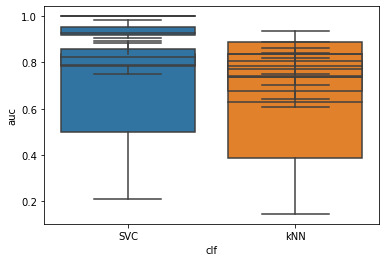

In [10]:
score_train_svc =[]
score_test_svc = []
auc_svc = []
score_train_knn =[]
score_test_knn = []
auc_knn = []
results = []
for i in range(2):
    auc_svc_train_R, auc_svc_test_R, auc_knn_train_R, auc_knn_test_R = prep(features,label)
    score_train_svc.append(auc_svc_train_R)
    score_test_svc.append(auc_svc_test_R)

    score_train_knn.append(auc_knn_train_R)
    score_test_knn.append(auc_knn_test_R)


    results.append({
    'auc' : auc_svc_test_R,
    'clf' : 'SVC'
    })
    
    results.append({
        'auc' : auc_knn_test_R,
        'clf' : 'kNN'
    })

print(
    'score_train_svc', np.mean(score_train_svc),
    'score_test_svc', np.mean(score_test_svc),
    'auc_svc', np.mean(auc_svc),
    'score_train_knn', np.mean(score_train_knn),
    'score_test_knn', np.mean(score_test_knn),
    'auc_knn', np.mean(auc_knn)
)

results = pd.DataFrame(results)
seaborn.boxplot(y='auc', x='clf', data=results)

Ttest_indResult(statistic=nan, pvalue=nan)

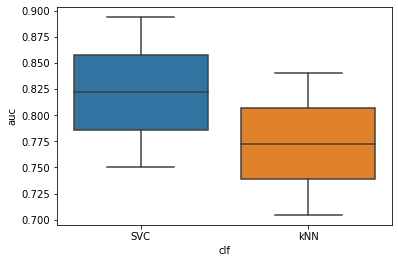

In [11]:
results = pd.DataFrame(results)

seaborn.boxplot(y='auc', x='clf', data=results)

from scipy.stats import ttest_ind
ttest_ind(auc_svc, auc_knn)

<AxesSubplot:xlabel='clf', ylabel='auc'>

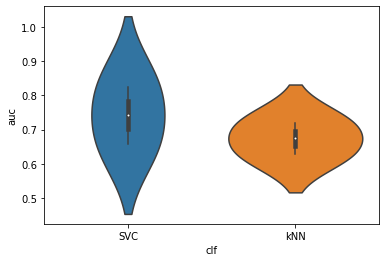

In [16]:
seaborn.violinplot(y='auc', x='clf', data=results)

In [24]:

np.max(auc_svc)

0.9696969696969697

In [38]:
print(results)

                                                 auc  clf
0  [0.8712121212121211, 0.9090909090909092, 0.916...  SVC
1  [0.6590909090909091, 0.8560606060606061, 0.848...  kNN
